In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:

df = pd.read_csv(r'input_to_renewal_classifier.csv')

In [3]:
print(df.shape)

df.head()

(1792, 7)


,Term_Clause,Renewal_Option,Fixed,Auto Renewal,Perpetual,Renewal,Termination
0,"""20. TERMINATION. Contract Renewal Term = Op...",Renewal,0,0,0,1,0
1,"-------------------- (a) The initial term (""In...",Auto Renewal,0,1,0,0,0
2,1. Term of Employment. The Company hereby agre...,Auto Renewal,0,1,0,0,0
3,2. Term: The term of this Agreement shall comm...,Auto Renewal,0,1,0,0,0
4,1. Term of Employment. The Corporation hereby ...,Auto Renewal,0,1,0,0,0


In [4]:
filter = df["Term_Clause"] != ""
df = df[filter]
df = df.dropna()

In [5]:
print(df["Term_Clause"][1068])


2. Term of Agreement. The term of this Agreement shall commence on the ------------------ date hereof and shall continue thereafter until terminated by either party giving at least 30 days' prior written notice to the other party.


In [6]:
df_labels = df[['Fixed','Auto Renewal','Perpetual','Renewal','Termination']]
df_labels.head()



,Fixed,Auto Renewal,Perpetual,Renewal,Termination
0,0,0,0,1,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [7]:
#from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
c =['Fixed','Auto Renewal','Perpetual','Renewal','Termination']

label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
encoded = label_encoder.fit_transform(c) 
  
print(encoded)
encoded.fit_transform(['Auto Renewal'])


[1 0 2 3 4]


AttributeError: 'numpy.ndarray' object has no attribute 'fit_transform'

In [ ]:
from sklearn.preprocessing import LabelEncoder
#import numpy as np 

c = ['France', 'UK', 'US', 'US', 'UK', 'China', 'France']
enc = LabelEncoder().fit(c)
encoded = enc.transform(c)
print(encoded)
# array([1, 2, 3, 3, 2, 0, 1])

# encoded.transform(['France'])
# array([1])

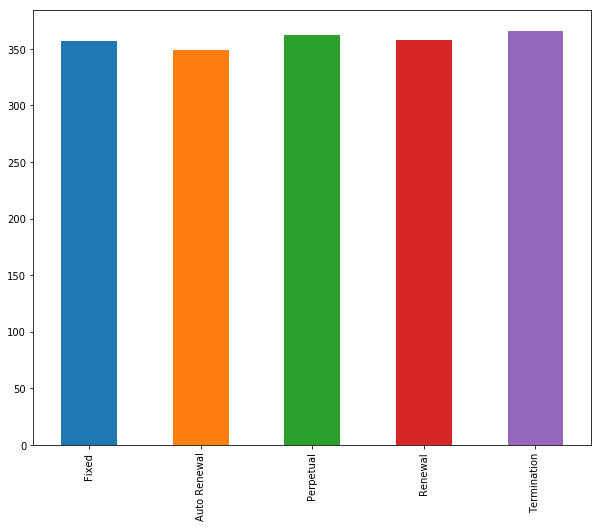

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_labels.sum(axis=0).plot.bar()

In [9]:
def preprocess_text(sen):
    # lowercase
    sentence = sen.lower()

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    #print(sentence)
    
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    print(sentence)
    return sentence


In [10]:
X = []
sentences = list(df["Term_Clause"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df_labels.values
print(df_labels)


 20 termination contract renewal term optional renewal conditions for renewal cw may renew for three additional 1 year terms in its sole discretion a prior to the termination or expiration and non renewal of the term of the agreement c w has the right in its sole discretion to extend the service term of any then current service addendum under this agreement for an additional period of one 1 year with c w having the right to repeat such extension up to three times up to total extension of the term of no more than three years b each extension of the term of any service addendum in accordance with subsection a shall be on the same terms and conditions of the agreement including pricing as exist at the point in time when the extension takes effect right to terminate at will cw only c c w has the right in its sole and absolute discretion and without payment of any penalty to terminate the agreement in whole or in part at any time during the term hereof upon thirty 30 days prior written term

4 term and termination 4 1 term this agreement shall remain in effect unless terminated in accordance with the provisions hereof 4 2 termination notwithstanding the foregoing licensor shall have the right subject to section 4 3 below to terminate this agreement without prejudice to any rights which it may have whether pursuant to this agreement or in law or equity or otherwise upon the occurrence of significant breach by licensee significant 13 page breach by licensee shall mean after exhaustion of any applicable cure periods set forth in this agreement any one or more of the following events a any of licensee an authorized dealer reseller value added reseller or any sublicensee uses the licensed marks in manner which fails to comply in all material respects with the provisions of this agreement and fails to cure such breach within sixty 60 days of receipt of written notice of such breach or b any use of the licensed marks by any of licensee an authorized dealer reseller value added re

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:




tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(X_train)


X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

maxlen = 8845

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

9059


In [13]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, Dropout, Activation,BatchNormalization
import keras
## create model
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, input_length=8845, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(GlobalMaxPooling1D())
#model_glove.add(LSTM(128))
model_glove.add(Dense(5, activation='sigmoid'))
model_glove.add(keras.layers.BatchNormalization())
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
## Fit train data
#history = model.fit(X_train, y_train, batch_size=128, epochs=80, verbose=1, validation_split=0.2)
model_glove.fit(X_train, y_train, batch_size=128, validation_split=0.2, epochs = 100)

Instructions for updating:
Colocations handled automatically by placer.


ValueError: Error when checking target: expected dense_2 to have shape (1,) but got array with shape (5,)

In [ ]:
print(model_glove.summary())


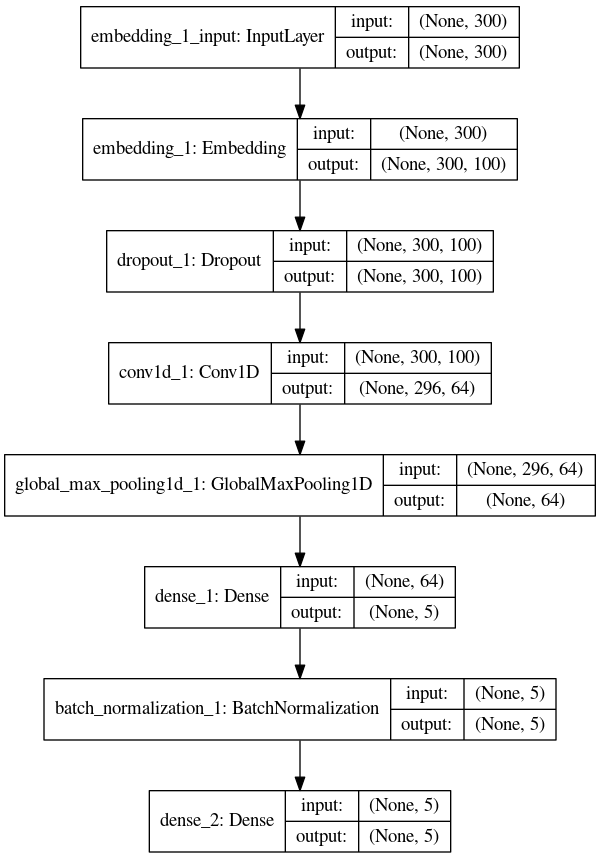

In [19]:
from keras.utils import plot_model
plot_model(model_glove, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [20]:
score = model_glove.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

358/358 [==============================] - 0s 227us/step
Test Score: 0.4418832413311111
Test Accuracy: 0.8849161863327026


In [19]:
import pickle

model_glove.save('model_keras_embedding_cnn.h5')

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [17]:
sent="20. TERMINATION.  Contract Renewal Term  = Optional Renewal Conditions for Renewal = CW may renew for three additional 1 year terms in its sole discretion (a) Prior to the termination or expiration and non-renewal of the Term of the Agreement, C&W has the right, in its sole discretion, to extend the Service Term of any then-current Service Addendum under this Agreement for an additional period of one (1) year, with C&W having the right to repeat such extension up to three times up to a total extension of the Term of no more than three years. (b)  Each extension of the term of any Service Addendum in accordance with subsection (a), shall be on the same terms and conditions of the Agreement (including pricing) as exist at the point in time when the extension takes effect. Right to Terminate  = At Will (CW Only) (c) C&W has the right, in its sole and absolute discretion and without payment of any penalty, to terminate the Agreement, in whole or in part, at any time during the term hereof upon thirty (30) days prior written Termination Notice = 30 days notice to Contractor. Any termination of this Agreement under this provision shall not affect the Parties\' rights and obligations thereunder that accrued prior to the date of termination, which shall survive such termination. (d)  If Contractor shall default in the performance of any of its obligations under the Agreement (including without limitation violation of any law), then, C&W has the right, without payment of any penalty, to terminate this Master Agreement, in whole or in part, immediately upon written notice to Contractor. Furthermore, the Agreement and C&W\’s obligation to pay any compensation to Contractor hereunder shall terminate immediately with respect to all transactions if the continuation of the Agreement would violate Applicable Anti-Corruption Laws (as such term is defined in Section 33(b) below). (e)  If a receiver, liquidator or trustee for Contractor shall be appointed by court order; or a petition shall be filed against Contractor under any bankruptcy, reorganization or insolvency law; or Contractor shall file a petition in voluntary bankruptcy or shall request reorganization under any provision of voluntary bankruptcy, reorganization or insolvency laws; or if Contractor shall make an assignment for the benefit of creditors, then the entire Agreement shall immediately terminate upon the happening of any such event. (f)  For clarity, any right of C&W to terminate the Agreement also allows C&W to terminate a Service Addendum, in whole or in part, without having to terminate the Agreement or any other Service Addendum. Termination of a Service Addendum shall not affect any other Service Addendum. Indemnity = Vendor Indemnity when this provision contains \"C&W Indemnitees\" only) 21. INDEMNIFICATION. If \"Contractor Indemnitees\" is found as well as \"C&W Indemnitees\" = Cross Indemnity If \"Contractor Indemnitees\" alone then = Cushman Indemnity (a) Contractor shall, to the fullest extent permitted by law, indemnify and hold harmless C&W, its Clients and their respective subsidiaries, Affiliates, shareholders, directors, officers, partners and employees (the “C&W Indemnitees”) from and against any and all liability, claims and demands on account of damage C&W CONFIDENTIAL Master Agreement Page 8 DocuSign Envelope ID: 39B691A7490BDAB-B96C-742E3F6F4DD9D903745-1FE3-4478-BDD1-6A6C5BE7F7EC to any property or injury to persons including death resulting therefrom, losses, damages, expenses (including attorneys’ fees and investigation costs), payments, recoveries and judgments in connection therewith, to the extent arising out of or caused in any manner by (i) any acts or omissions of Contractor, its Affiliates and Contractor Personnel; (ii) the performance or failure to perform any Services under the Agreement; (iii) the breach of any representation or warranty or covenant or condition set forth in the Agreement by Contractor, its Affiliates or Contractor Personnel; (iv) the use of any C&W’s tools or equipment by Contractor, its Affiliates or Contractor Personnel; (v) a breach of any obligation for which Contractor is responsible as employer or contractor of Contractor Personnel, including (as examples): (A) Contractor’s employment of one or more of Contractor’s employees; (B) any claim alleging that any of the C&W Indemnitees should be deemed the “employer” or “joint employer” of any Contractor Personnel, and (C) any claim by any member or former member of Contractor Personnel, alleging unfair dismissal, breach of contract, discrimination on the grounds of sex, race, disability, sexual orientation, religion or belief, age or equal pay; (vi) the violation of any applicable law, order, or regulation by Contractor, its Affiliates or Contractor Personnel; or (vii) any claim arising from or relating to work-related injuries of Contractor or Contractor Personnel (including the employees, agents, subcontractors and suppliers of Contractor Personnel). (b)  In addition, Contractor shall indemnify, hold harmless and defend, at its sole cost and expense, the C&W Indemnitees from any loss, damage, expense (including attorneys’ fees and costs), payment, recovery and judgment arising out of any claim or threatened claim, alleging that any Services furnished hereunder infringe upon or violate a patent, copyright, trademark, trade secret or other proprietary right of any third party. C&W, at its sole cost and expense, shall have the right to be represented in any such action or proceeding by independent counsel of C&W's own choice. Contractor's liability under this subsection (b) shall survive the expiration or termination of the Agreement, but this shall not be construed to mean that Contractor's liability does not survive as to other provisions of the Agreement. (c) Contractor shall, at its own expense, defend any and all actions brought against C&W based upon any of the foregoing and shall pay all attorneys’ fees and all other expenses, and promptly discharge any judgments, settlements or compromises arising therefrom. No third party claim or action may be settled or compromised by Contractor without C&W’s prior written consent, unless the settlement or compromise includes a release of all claims against C&W and Client as applicable by the party bringing the claim or action; and C&W will have the right at its sole expense to participate in the legal proceeding with counsel of its own choosing. C&W will assist and cooperate in the defense as reasonably requested by Contractor, at Contractor’s expense. (d) Contractor's liability under this Section 21 (Indemnification) shall survive the expiration or termination of the Agreement, but this shall not be construed to mean that Contractor's liability does not survive as to other provisions of the Agreement."

In [21]:
import tensorflow as tf
from keras.models import load_model
from keras import backend as K

import pickle
# with tf.Graph().as_default():
#     with tf.Session() as sess:
model_glove1= load_model('model_keras_embedding_cnn.h5')
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

print(max_len)
max_len =8845
#         K.set_session(sess)
#         K.graph = tf.get_default_graph()
#         K.graph.finalize()
sent=sent.lower()
sent = re.sub(r"\s+[a-zA-Z]\s+", ' ', sent)

# Removing multiple spaces
sent = re.sub(r'\s+', ' ', sent)
#print(sentence)
    
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
X = tokenizer1.texts_to_sequences([sent])
padded = pad_sequences(X, maxlen=max_len)
pred = model_glove1.predict(padded)

labels=['Fixed','Auto Renewal','Perpetual','Renewal','Termination']
print(pred, labels[np.argmax(pred)])


AttributeError: 'str' object has no attribute 'read_bytes'

In [18]:
from pathlib import Path
import pickle
import tensorflow as tf
from keras.models import load_model
from keras import backend as K

renewal_options_model_dir = Path("renewal option/CNN_GLOBALMAX_new_model/")


# category = pickle.loads((renewal_options_model_dir / "new_labels2.pkl").read_bytes())
# tokenizer1, max_len = pickle.loads((renewal_options_model_dir / "new_tokenizer2.pkl").read_bytes())

In [19]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
def classify_renewal_option(sent):
#     from keras import backend as K
#     K.clear_session()

    #model1 = load_model(str(renewal_options_model_dir / "model-042-0.978191-0.902299.hdf5"))
    model_glove1= load_model(str(renewal_options_model_dir / "model-042-0.978191-0.902299.hdf5"))
    print("hi")
    print(model_glove1.summary())
#     with open('tokenizer.pkl', 'rb') as handle:
#         tokenizer1 = pickle.load(handle)

#     X = tokenizer1.texts_to_sequences([sent])
#     X = pad_sequences(X, maxlen=max_len)
#     predicted = model1.predict(X)
#     class_output = category[predicted.argmax()]
    
#     return class_output



classify_renewal_option(sent)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
hi
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3923, 300)         1994700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3923, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3921, 150)         135150    
_________________________________________________________________
dropout_2 (Dropout)          (None, 3921, 150)         0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38